In [1]:
#!/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/bin/python

#
#  Works in CPU Mode not GPU
#

#Standard Header used on the projects
# %%
Computer = "SciClone" # "SciClone"    "WinLap"  "LinLap"   "Desktop" 


#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import os as os
import random
import multiprocessing
from joblib import Parallel, delayed

import pywt
from pywt._extensions._pywt import (DiscreteContinuousWavelet, ContinuousWavelet,
                                Wavelet, _check_dtype)
from pywt._functions import integrate_wavelet, scale2frequency
from time import time as ti
import datetime

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import  EarlyStopping
 
import cv2
from sklearn.model_selection import train_test_split
#import tensorflow.keras_metrics as km
  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix


if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
    

if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/data10/dchendrickson01/SmallCopy/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "SmallCopy\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "SmallCopy\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'SmallCopy/'
    

scales = 500
#img_height , img_width = scales, 200
FrameLength = 600
numberFrames = 600
DoSomeFiles = True
NumberOfFiles = 15
SmoothType = 1  # 0 = none, 1 = rolling average, 2 = rolling StdDev
SmoothDistance=25
TrainEpochs = 1
WaveletToUse = 'gaus2'
num_cores = multiprocessing.cpu_count() -1
SensorPositonFile = rootfolder + 'SensorStatsSmall.csv'
if Computer == "SciClone" or Computer == "LinLap":
    SaveModelFolder = rootfolder + 'SavedModel/'
else:
    SaveModelFolder = rootfolder + 'SavedModel\\'

files = os.listdir(folder)
if DoSomeFiles: files = random.sample(files,NumberOfFiles)

GroupSize = 15
OutputVectors = np.genfromtxt(open(SensorPositonFile,'r'), delimiter=',',skip_header=1,dtype=int, missing_values=0)

In [2]:
import CoreFunctions as cf

In [3]:
def cwt_fixed(data, scales, wavelet, sampling_period=1., spacer = 5):
    """
    COPIED AND FIXED FROM pywt.cwt TO BE ABLE TO USE WAVELET FAMILIES SUCH
    AS COIF AND DB

    COPIED From Spenser Kirn
    
    All wavelet work except bior family, rbio family, haar, and db1.
    
    cwt(data, scales, wavelet)

    One dimensional Continuous Wavelet Transform.

    Parameters
    ----------
    data : array_like
        Input signal
    scales : array_like
        scales to use
    wavelet : Wavelet object or name
        Wavelet to use
    sampling_period : float
        Sampling period for frequencies output (optional)

    Returns
    -------
    coefs : array_like
        Continous wavelet transform of the input signal for the given scales
        and wavelet
    frequencies : array_like
        if the unit of sampling period are seconds and given, than frequencies
        are in hertz. Otherwise Sampling period of 1 is assumed.

    Notes
    -----
    Size of coefficients arrays depends on the length of the input array and
    the length of given scales.

    Examples
    --------
    >>> import pywt
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> x = np.arange(512)
    >>> y = np.sin(2*np.pi*x/32)
    >>> coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
    >>> plt.matshow(coef) # doctest: +SKIP
    >>> plt.show() # doctest: +SKIP
    ----------
    >>> import pywt
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> t = np.linspace(-1, 1, 200, endpoint=False)
    >>> sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))
    >>> widths = np.arange(1, 31)
    >>> cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
    >>> plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
    ...            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
    >>> plt.show() # doctest: +SKIP
    """

    # accept array_like input; make a copy to ensure a contiguous array
    dt = _check_dtype(data)
    data = np.array(data, dtype=dt)
    if not isinstance(wavelet, (ContinuousWavelet, Wavelet)):
        wavelet = DiscreteContinuousWavelet(wavelet)
    if np.isscalar(scales):
        scales = np.array([scales])*spacer
    if data.ndim == 1:
        try:
            if wavelet.complex_cwt:
                out = np.zeros((np.size(scales), data.size), dtype=complex)
            else:
                out = np.zeros((np.size(scales), data.size))
        except AttributeError:
            out = np.zeros((np.size(scales), data.size))
        for i in np.arange(np.size(scales)):
            precision = 10
            int_psi, x = integrate_wavelet(wavelet, precision=precision)
            step = x[1] - x[0]
            j = np.floor(
                np.arange(scales[i] * (x[-1] - x[0]) + 1) / (scales[i] * step))
            if np.max(j) >= np.size(int_psi):
                j = np.delete(j, np.where((j >= np.size(int_psi)))[0])
            coef = - np.sqrt(scales[i]) * np.diff(
                np.convolve(data, int_psi[j.astype(int)][::-1]))
            d = (coef.size - data.size) / 2.
            out[i, :] = coef[int(np.floor(d)):int(-np.ceil(d))]
        frequencies = scale2frequency(wavelet, scales, precision)
        if np.isscalar(frequencies):
            frequencies = np.array([frequencies])
        for i in np.arange(len(frequencies)):
            frequencies[i] /= sampling_period
        return out, frequencies
    else:
        raise ValueError("Only dim == 1 supported")

def getThumbprint(data, wvt=WaveletToUse, ns=scales, numslices=5, slicethickness=0.12, 
                  valleysorpeaks='both', normconstant=1, plot=True):
    '''
    STarted with Spenser Kirn's code, modifed by DCH
    Updated version of the DWFT function above that allows plotting of just
    valleys or just peaks or both. To plot just valleys set valleysorpeaks='valleys'
    to plot just peaks set valleysorpeaks='peaks' or 'both' to plot both.
    '''
    # First take the wavelet transform and then normalize to one
    cfX, freqs = cwt_fixed(data, np.arange(1,ns+1), wvt)
    cfX = np.true_divide(cfX, abs(cfX).max()*normconstant)
    '''
    fp = np.zeros((len(data), ns), dtype=int)
    
    # Create the list of locations between -1 and 1 to preform slices. Valley
    # slices will all be below 0 and peak slices will all be above 0.
    if valleysorpeaks == 'both':
        slicelocations1 = np.arange(-1 ,0.0/numslices, 1.0/numslices)
        slicelocations2 = np.arange(1.0/numslices, 1+1.0/numslices, 1.0/numslices)
        slicelocations = np.array(np.append(slicelocations1,slicelocations2))
        
    for loc in slicelocations:
        for y in range(0, ns):
            for x in range(0, len(data)):
                if cfX[y, x]>=(loc-(slicethickness/2)) and cfX[y,x]<= (loc+(slicethickness/2)):
                    fp[x,y] = 1
                    
    fp = np.transpose(fp[:,:ns])
    return fp
    '''
    return cfX

def RidgeCount(fingerprint):
    '''
    From Spencer Kirn
    Count the number of times the fingerprint changes from 0 to 1 or 1 to 0 in 
    consective rows. Gives a vector representation of the DWFT
    '''
    diff = np.zeros((fingerprint.shape))
    
    for i, row in enumerate(fingerprint):
        if i==0:
            prev = row
        else:
            # First row (i=0) of diff will always be 0s because it does not
            # matter what values are present. 
            # First find where the rows differ
            diff_vec = abs(row-prev)
            # Then set those differences to 1 to be added later
            diff_vec[diff_vec != 0] = 1
            diff[i, :] = diff_vec
            
            prev = row
            
    ridgeCount = diff.sum(axis=0)
    
    return ridgeCount

def Smoothing(RawData, SmoothType = 3, SmoothDistance=15):

    if SmoothType == 0:
        SmoothedData = RawData
    elif SmoothType ==1:
        SmoothedData = RawData
        if np.shape(np.shape(RawData))== 2:
            for i in range(SmoothDistance-1):
                for j in range(3):
                    SmoothedData[j,i+1]=np.average(RawData[j,0:i+1])
            for i in range(np.shape(RawData)[0]-SmoothDistance):
                for j in range(3):
                    SmoothedData[j,i+SmoothDistance]=np.average(RawData[j,i:i+SmoothDistance])
        elif np.shape(np.shape(RawData))== 1:
            for i in range(SmoothDistance-1):
                SmoothedData[i+1]=np.average(RawData[0:i+1])
            for i in range(np.shape(RawData)[0]-SmoothDistance):
                SmoothedData[i+SmoothDistance]=np.average(RawData[i:i+SmoothDistance])
    elif SmoothType == 3:
        SmoothedData = cf.KalmanFilterDenoise(RawData)

    return SmoothedData

def getRAcceleration(Data):
    rVals = []
    for i in range(np.shape(Data)[0]):
        rVals.append(np.sqrt(Data[i,0]**2+Data[i,1]**2+Data[i,2]**2))
    return rVals

def getAcceleration(FileName):
    try:
        DataSet = np.genfromtxt(open(folder+FileName,'r'), delimiter=',',skip_header=0)
        #rData = getRAcceleration(DataSet[:,2:5])
        #rSmoothed = Smoothing(rData)
        xSmoothed = Smoothing(DataSet[:,2])
        ySmoothed = Smoothing(DataSet[:,3])
        zSmoothed = Smoothing(DataSet[:,4])
        #return [[FileName,'x',DataSet[:,2]],[FileName,'y',DataSet[:,3]],[FileName,'z',DataSet[:,4]],[FileName,'r',rData]]
        return [FileName, 'r', [xSmoothed, ySmoothed, zSmoothed]]
    except:
        return [False,FileName,False]

def makePrints(DataArray):
    try:
        FingerPrint = getThumbprint(DataArray[2],'gaus2')
        return [DataArray[0],DataArray[1],FingerPrint.T]
    except:
        return [DataArray[0], 'Fail', np.zeros(60000,500)]

In [4]:
def makeMatrixPrints(DataMatrix):

    xPrint = getThumbprint(np.asarray(DataMatrix[0]).flatten())
    yPrint = getThumbprint(np.asarray(DataMatrix[1]).flatten())
    zPrint = getThumbprint(np.asarray(DataMatrix[2]).flatten())

    PrintMatrix = np.dstack((xPrint,yPrint,zPrint))
    
    return [PrintMatrix]

In [5]:
def getResults(FPnMd):
    Ridges = RidgeCount(FPnMd[2][:,500:59500])
    return [FPnMd[0],FPnMd[1],Ridges]

def CountAboveThreshold(Ridges, Threshold = 10):
    Cnum = np.count_nonzero(Ridges[2] >= Threshold)
    return [Ridges[0],Ridges[1],Cnum]

def truthVector(Filename):
    # Parses the filename, and compares it against the record of sensor position on cranes
    # inputs: filename
    # outputs: truth vector


    #Parsing the file name.  Assuming it is in the standard format
    sSensor = Filename[23]
    sDate = datetime.datetime.strptime('20'+Filename[10:21],"%Y%m%d-%H%M")

    mask = []

    i=0
    #loops through the known sensor movements, and creates a filter mask
    for spf in OutputVectors:
        
        startDate = datetime.datetime.strptime(str(spf[0])+str(spf[1]).zfill(2)+str(spf[2]).zfill(2)
            +str(spf[3]).zfill(2)+str(spf[4]).zfill(2),"%Y%m%d%H%M")
        #datetime.date(int(spf[0]), int(spf[1]), int(spf[2])) + datetime.timedelta(hours=spf[3]) + datetime.timedelta(minutes=spf[4])
        endDate = datetime.datetime.strptime(str(spf[5])+str(spf[6]).zfill(2)+str(spf[7]).zfill(2)
            +str(spf[8]).zfill(2)+str(spf[9]).zfill(2),"%Y%m%d%H%M")
        #datetime.date(int(spf[5]), int(spf[6]), int(spf[7])) + datetime.timedelta(hours=spf[8]) + datetime.timedelta(minutes=spf[9])
        
        if sDate >= startDate and sDate <= endDate and int(spf[10]) == int(sSensor):
            mask.append(True)
            i+=1
        else:
            mask.append(False)
        
    if i != 1: print('error ', i, Filename)

    results = OutputVectors[mask,11:]

    if i > 1: 
        print('Found Two ', Filename)
        results = results[0,:]
    #np.array(results)

    return results

def makeFrames(input): #,sequ,frameLength):
    frames=[] #np.array([],dtype=object,)
    segmentGap = int((np.shape(input)[1]-FrameLength)/numberFrames)
    #print(segmentGap,sequ, frameLength)
    for i in range(numberFrames):
        start = i * segmentGap
        imageMatrix = input[:,start:start+FrameLength]
        np.matrix(imageMatrix)
        imageMatrix = imageMatrix.T

        w0=int(np.shape(imageMatrix)[0]/2)
        a0=np.linspace(0,w0-1,w0,dtype=int)*2
        imageMatrix = np.delete(imageMatrix,a0,axis=0)

        w1=int(np.shape(imageMatrix)[1]/2)
        a1=np.linspace(0,w1-1,w1,dtype=int)*2
        imageMatrix = np.delete(imageMatrix,a1,axis=1)

        #for j in range(np.shape(imageMatrix)[0]):
        #    for k in range(np.shape(imageMatrix)[1]):
        #        imageMatrix[j,k] = [imageMatrix[j,k]]

        frames.append(np.asarray(imageMatrix))
    
    return frames

def make3dFrames(input, SizeReduction = 2): #,sequ,frameLength):
    frames=[] #np.array([],dtype=object,)
    segmentGap = int((np.shape(input)[1]-FrameLength)/numberFrames)
    #print(segmentGap,sequ, frameLength)
    for i in range(numberFrames):
        start = i * segmentGap
        imageMatrix = input[:,start:start+FrameLength,:]
        #np.matrix(imageMatrix)
        #imageMatrix = imageMatrix.T

        w0=int(np.shape(imageMatrix)[0]/SizeReduction)
        a0=np.linspace(0,w0-1,w0,dtype=int)*SizeReduction
        imageMatrix = np.delete(imageMatrix,a0,axis=0)

        w1=int(np.shape(imageMatrix)[1]/SizeReduction)
        a1=np.linspace(0,w1-1,w1,dtype=int)*SizeReduction
        imageMatrix = np.delete(imageMatrix,a1,axis=1)

        
        w0=int(np.shape(imageMatrix)[0]/SizeReduction)
        a0=np.linspace(0,w0-1,w0,dtype=int)*SizeReduction
        imageMatrix = np.delete(imageMatrix,a0,axis=0)

        w1=int(np.shape(imageMatrix)[1]/SizeReduction)
        a1=np.linspace(0,w1-1,w1,dtype=int)*SizeReduction
        imageMatrix = np.delete(imageMatrix,a1,axis=1)
        #for j in range(np.shape(imageMatrix)[0]):
        #    for k in range(np.shape(imageMatrix)[1]):
        #        imageMatrix[j,k] = [imageMatrix[j,k]]

        frames.append(np.asarray(imageMatrix,dtype=int))
    
    return frames

In [6]:
def ParseData(FPwMD):

    frames = np.asarray(make3dFrames(FPwMD))

    #Results = truthVector(FPwMD[0])

    return frames #, Results

In [7]:
if np.size(files) % GroupSize == 0:
    loops = int(np.size(files)/GroupSize)
else:
    loops = int(float(np.size(files))/float(GroupSize))+1

AllFingers = []

AllAccels = Parallel(n_jobs=num_cores)(delayed(cf.getAcceleration)(file) for file in files)
Flattened = []
for j in range(np.shape(AllAccels)[0]):
    if AllAccels[j][0] == False:
        print(j,AllAccels[j][1])
    else: 
        Flattened.append(AllAccels[j])
print('Have Data')

Have Data


/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [8]:
MetaData = []  #np.asarray([],dtype=object)
DataOnlyMatrix = np.asarray([],dtype=object)
for j in range(np.shape(AllAccels)[0]):
    if AllAccels[j][0] == False :
        if AllAccels[j][1][4:9] =='Accel':
            print(j,AllAccels[j][1])
    else: 
        for k in range(3):
            MetaData.append([AllAccels[j][k][0], AllAccels[j][k][1], AllAccels[j][k][3], AllAccels[j][k][4]])
            if np.size(DataOnlyMatrix) == 0:
                    DataOnlyMatrix =np.matrix(AllAccels[j][k][2])
            else:
                    DataOnlyMatrix = np.concatenate((DataOnlyMatrix,np.matrix(AllAccels[j][k][2])),axis=0)

MetaData = np.matrix(MetaData)

In [9]:
def KalmanGroup(DataMatrix):
    waveKalmaned = np.asarray([],dtype=object)
    waveKalmaned = Parallel(n_jobs=num_cores)(delayed(cf.KalmanFilterDenoise)(np.asarray(data).flatten()) for data in DataMatrix)
    waveKalmaned = np.matrix(waveKalmaned)
    length = np.shape(waveKalmaned)[0]
    justifier = np.ones((length, np.shape(waveKalmaned)[1]))
    average = np.zeros(length)
    for i in range(length):
        average[i]= np.average(waveKalmaned[i][:])
    justifier = justifier.T * average.T
    waveKalmaned = waveKalmaned - justifier.T
    
    return waveKalmaned

In [10]:
AllAccels = KalmanGroup(DataOnlyMatrix)

/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could

In [11]:
maxes = np.amax(AllAccels[:,500:], axis = 1)
mins = np.amin(AllAccels[:,500:], axis = 1)

Keep = np.zeros(mins.size)
for i in range(mins.size):
    if i % 3 == 0:
        if maxes[i] > 0.01 and mins[i] < -0.01:
            Keep[i]=1
            Keep[i+1]=1
            Keep[i+2]=1
            #print(i)
            

Keep = np.array(Keep, dtype='bool')
            
AllAccels = AllAccels[Keep,:]
MetaData = MetaData[Keep,:]

In [12]:
MotionsLeft = int(np.shape(AllAccels)[0]/3.0)

In [13]:
AllFingers =  Parallel(n_jobs=num_cores)(delayed(makeMatrixPrints)([AllAccels[i*3],AllAccels[i*3+1],AllAccels[i*3+2]]) for i in range(MotionsLeft))

print('Have fingerprints')

Have fingerprints


In [14]:
DataSet = Parallel(n_jobs=num_cores)(delayed(ParseData)(file[0]) for file in AllFingers)
DataSet = np.asarray(DataSet)

In [15]:
ResultsSet = []
for i in range(MotionsLeft):
    ResultsSet.append(np.asarray(cf.truthVector(MetaData[i*3,3])).flatten())

print('Data Parsed')

Data Parsed


In [16]:
np.shape(DataSet)

(10, 600, 125, 150, 3)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(DataSet, ResultsSet, test_size=0.20, shuffle=True, random_state=0)

In [18]:
del DataSet, ResultsSet, AllFingers, MetaData,AllAccels,Flattened

In [19]:
y_train = np.matrix(y_train)

print(np.shape(y_train), np.shape(X_train))

(8, 4) (8, 600, 125, 150, 3)


In [20]:
model = Sequential()
model.add(ConvLSTM2D(filters = 16, 
            kernel_size = (5, 5), 
            return_sequences = False, 
            data_format = "channels_last", 
            input_shape = (numberFrames, np.shape(X_train[0][0])[0], np.shape(X_train[0][0])[1],3)
            )
        )
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(np.shape(y_train)[1], activation = "softmax"))
 
model.summary()

 
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=7)   
callbacks = [earlystop]

2022-06-26 14:09:59.630218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64/stubd:/usr/local/cuda-11.7/nvvm/lib64:/lib64:/usr/lib64:/usr/local/torque-6.1.1.1/lib:/usr/local/anaconda3-2021.11/lib
2022-06-26 14:09:59.630283: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-26 14:09:59.630310: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hi01.sciclone.wm.edu): /proc/driver/nvidia/version does not exist
2022-06-26 14:09:59.630730: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 121, 146, 16)      30464     
                                                                 
 dropout (Dropout)           (None, 121, 146, 16)      0         
                                                                 
 flatten (Flatten)           (None, 282656)            0         
                                                                 
 dense (Dense)               (None, 32)                9045024   
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 9,075,620
Trainable params: 9,075,620
Non-

In [21]:
history = model.fit(x = X_train, y = y_train, epochs=3, batch_size = 8 , shuffle=False, validation_split=0.25, callbacks=callbacks)

Epoch 1/3
1/1 [==============================] - 80s 80s/step - loss: 1.3849 - accuracy: 0.1667 - val_loss: 1.3623 - val_accuracy: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 69s 69s/step - loss: 1.3781 - accuracy: 0.5000 - val_loss: 1.6038 - val_accuracy: 0.0000e+00
Epoch 3/3
1/1 [==============================] - 69s 69s/step - loss: 1.4191 - accuracy: 0.3333 - val_loss: 1.3146 - val_accuracy: 0.5000


2022-06-26 14:13:39.796190: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /sciclone/home20/dchendrickson01/SavedModel/assets


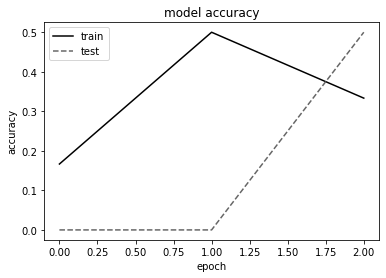

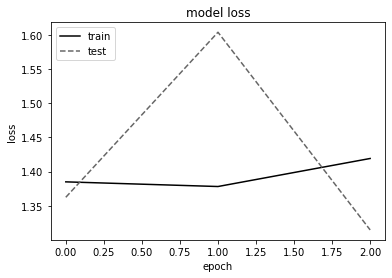

In [22]:
model.save(SaveModelFolder)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(rootfolder + 'ModelAccuracy.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(rootfolder + 'ModelLoss.png')
plt.show()